# Optimization for Machine Learning: Computer Lab 1

## 2. Preprocessing the data

Here, we load the data, standardize it, and set it in the appropriate shape for performing linear regression. You do not need to complete anything in this section; however it is important that you understand what the code is doing. See the pdf instructions for more details.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading data
data_matrix_train, COP_train, data_matrix_test, COP_test, names = np.load('../data_center_data_matrix.npy', allow_pickle=True)

In [3]:
# centering and normalizing the matrix
matrix_mean = np.mean(data_matrix_train, axis=0)
M = data_matrix_train - matrix_mean

matrix_std = np.std(M, axis=0)
M = M / matrix_std


In [4]:
M.shape


(722, 892)

In [5]:
COP_train.shape

(722, 4)

In [6]:
data_matrix_test.shape

(361, 892)

In [7]:
# Building the corresponding matrices A,b for linear regression
A = np.hstack([M, np.ones((M.shape[0],1)), -(M.T * COP_train[:,3]).T])
b = COP_train[:,3]

print(A.shape)


# Building the same matrices for the test set
M_test = (data_matrix_test - matrix_mean) / matrix_std
A_test = np.hstack([M_test, np.ones((M_test.shape[0],1)), -(M_test.T * COP_test[:,3]).T])
b_test = COP_test[:,3]

print(A_test.shape)

d = A.shape[1]

(722, 1785)
(361, 1785)


## 3. Ordinary least squares

We now wish to solve the problem
$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2
$$

In [8]:
## Question 3.2: solve with the numpy least squares solver

# COMPLETE HERE
w_least_squares = np.linalg.lstsq(A, b, rcond=None)[0]
print(w_least_squares.shape)


(1785,)


In [9]:
## Question 3.3

# COMPLETE HERE
test_error = (1/A_test.shape[0]) * np.linalg.norm(A_test @ w_least_squares - b_test)**2
print("Test error for least squares solution : ", test_error)

Test error for least squares solution :  780.8984793523532


In [10]:
x = np.array(
    [89, 34, 56, 87, 90, 23, 45, 12, 65, 78, 9, 34, 12, 11, 2, 65, 78, 82, 28, 78]
)
norm = 0
for v in x:
    norm += v**2

print(np.sqrt(norm))
print(np.linalg.norm(x))

257.4800963181426
257.4800963181426


In [11]:
Matrix1_test = np.array([[1,2],[0,1]])
Matrix2_test = np.array([[2,0],[0,1]])
vect_test = np.array([1,1])

print(Matrix1_test @ vect_test)
print(Matrix1_test * vect_test)

print(Matrix1_test @ Matrix2_test)
print(Matrix1_test * Matrix2_test)

print(Matrix1_test.T)

[3 1]
[[1 2]
 [0 1]]
[[2 2]
 [0 1]]
[[2 0]
 [0 1]]
[[1 0]
 [2 1]]


### Adding $\ell_2$ regularization

In order to improve the performance on the test set, we add $\ell_2$ regularization:

$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2 + \frac \lambda 2 \|w\|_2^2
$$

In [12]:
lambda_l2 = 1e4

In [13]:
# Question 3.5
def f(w):
    return 1/2 * np.linalg.norm(A@w - b)**2 + lambda_l2/2 *  np.linalg.norm(w)**2

def grad_f(w):
    return A.T @ (A @ w - b) + lambda_l2 * w

def gradient_descent(func, w0, gamma, max_iter):
    w = w0.copy()
    
    f_values = []
    gradient_norms = []

    for t in range(max_iter):
        # COMPLETE HERE 
        w = w - gamma * grad_f(w)
        
        f_values.append(func(w))
        gradient_norms.append(np.linalg.norm(grad_f(w)))
        
    return w, f_values, gradient_norms


For finding the appropriate step size range, we need to estimate the Lipschitz constant of the gradient.

In [14]:
# COMPLETE HERE
L_ = np.linalg.eigvals(A.T @ A - lambda_l2 * np.identity(A.shape[1]))
L = np.abs(L_[0])

In [15]:
# COMPLETE HERE
w0 = np.zeros(A.shape[1])
step_size = 1/L
max_iter = 4000

w_GD, f_values_GD, gradient_norms_GD = gradient_descent(f, w0, step_size, max_iter)


We now compute the evolution of function values and gradient norm. 

Text(0, 0.5, 'Function values')

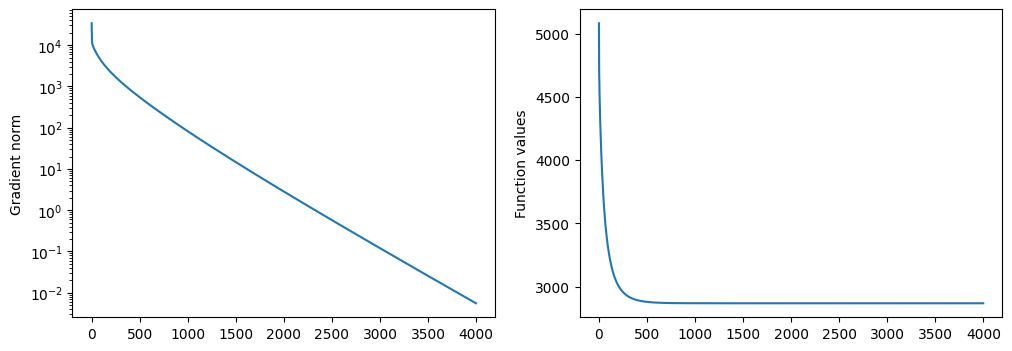

In [16]:
# let us plot the result 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(gradient_norms_GD)
axes[0].semilogy()
axes[0].set_ylabel("Gradient norm")

axes[1].plot(f_values_GD)
axes[1].set_ylabel("Function values")

In [17]:
# Question 3.6 
test_error_l2 = 1/A_test.shape[0] * np.linalg.norm(A_test @ w_GD - b_test)**2
print("Test error for l2 penalized solution : ", test_error_l2)

Test error for l2 penalized solution :  61.516746269369364


What do you observe ?

For a faster algorithm, we could implement accelerated gradient descent.

In [18]:
# Question 3.7 (optional) 

def accelerated_gradient_descent(func, w0, gamma, max_iter):
    w = w0.copy()
    y_ = 0
    
    f_values = []
    gradient_norms = []

    for t in range(max_iter):
        # COMPLETE HERE 
        y = w - gamma * grad_f(w)
        w = y + t/(t+3) * (y - y_)
        y_ = y
        
        f_values.append(f(w))
        gradient_norms.append(np.linalg.norm(grad_f(w)))
        
    return w, f_values, gradient_norms

In [19]:
# COMPLETE HERE
w0 = np.zeros(A.shape[1])
step_size = 1/L
max_iter = 4000

w_AGD, f_values_AGD, gradient_norms_AGD = accelerated_gradient_descent(f, w0, step_size, max_iter)


index_grad_under1       = 0
index_acc_grad_under1   = 0
for i in range(len(f_values_GD)):
    if gradient_norms_GD[i] < 1 and index_grad_under1 == 0:
        index_grad_under1 = i
    if gradient_norms_AGD[i] < 1 and index_acc_grad_under1 == 0:
        index_acc_grad_under1 = i

print(index_grad_under1)    
print(index_acc_grad_under1)

2326
1075


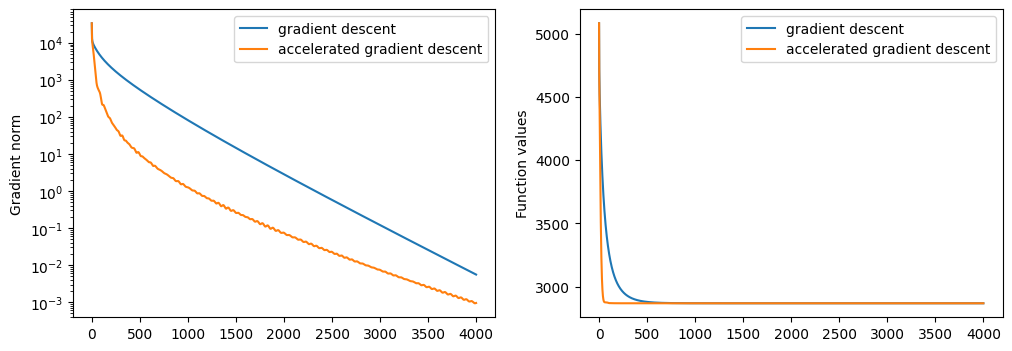

In [20]:
# let us plot the result 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

axes[0].plot(gradient_norms_GD, label = "gradient descent")
axes[0].plot(gradient_norms_AGD, label = "accelerated gradient descent")
axes[0].semilogy()
axes[0].set_ylabel("Gradient norm")
axes[0].legend()

axes[1].plot(f_values_GD, label = "gradient descent")
axes[1].plot(f_values_AGD, label = "accelerated gradient descent")
axes[1].set_ylabel("Function values")
axes[1].legend()

What do you observe regarding the convergence speed ?

## 4. Adding $\ell_1$ regularization (Lasso)

We now solve 

$$
\min_{w \in \mathbb{R}^d} \frac 12 \|Aw-b\|_2^2 + \lambda \|w\|_1
$$

In [21]:
L_ = np.linalg.eigvals(A.T @ A)
L = np.abs(L_[0])

In [22]:
lambda_l1 = 1e3

## Question 4.2
def prox_l1(x, mu = 1.):
    """compute the proximal operator of mu * |x|_1
    """
    return np.sign(x) * np.maximum(np.abs(x) - mu, 0)

def F2(w):
    return 1/2 * np.linalg.norm(A@w - b)**2 + lambda_l1 * np.linalg.norm(x, ord=1)

def grad_f2(w):
    return A.T @ (A @ w - b) 


def proximal_gradient_descent(func, w0, gamma, max_iter):
    w = w0.copy()

    f_values = []
    gradient_norms = []

    for t in range(max_iter):
        w = prox_l1(w - gamma * grad_f2(w), gamma * lambda_l1)

        f_values.append(F2(w))
        gradient_norms.append(np.linalg.norm(grad_f2(w)))
        
    return w, f_values, gradient_norms

In [23]:
# COMPLETE HERE
w0 = np.zeros(A.shape[1])
step_size = 1/L
max_iter = 4000

w_PGD, f_values_PGD, gradient_norms_PGD = proximal_gradient_descent(F2, w0, step_size, max_iter)


In [24]:
# Question 4.3

test_error_l1 = 1/A_test.shape[0] * np.linalg.norm(A_test @ w_PGD - b_test)**2
print("Test error for l1 penalized solution : ", test_error_l1)

Test error for l1 penalized solution :  3.4196947803554605


Compare with the previous test errors. What do you observe?

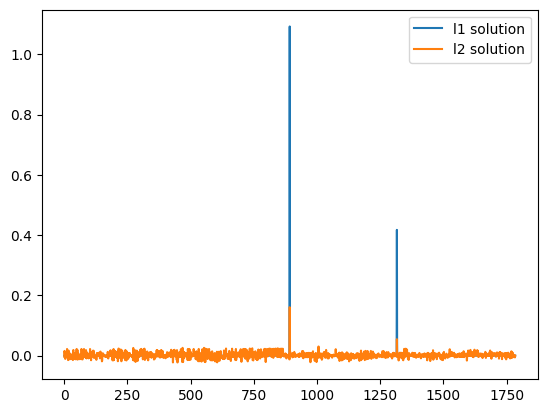

In [25]:
# Let us examine the solution
plt.plot(w_PGD, label = "l1 solution")
plt.plot(w_GD, label = "l2 solution")
plt.legend()


In [26]:
# Question 4.4
def proximal_gradient_descent_linesearch(func, w0, gamma, max_iter):
    # COMPLETE HERE
    #...

_IncompleteInputError: incomplete input (4278252193.py, line 4)

## Tuning the penalization parameter

How to find the best solution among all those that were comptued? How to choose the penalization parameter $\lambda$?

In [ ]:
# Your method here...